In [20]:
'''
Here, we plot PDGrapher performance as a function of the loss function components
Chemical dataset, random splitting
'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as osp
from glob import glob
import sys
sys.path.append('../../')
from constants import *
import os
import numpy as np
from scipy import stats


outdir = 'processed'
os.makedirs(outdir, exist_ok = True)
performance = {}

def add_to_performance(df, cell_line, method_name, performance):
    # Populate the dictionary
    for index, row in df.iterrows():
        metric = row['Metric']
        if metric == 'ranking score':
            metric = 'rankings'
        if cell_line not in performance:
            performance[cell_line] = {}
            
        if metric not in performance[cell_line]:
            performance[cell_line][metric] = {method_name: []}

        values = [row['Fold 1'], row['Fold 2'], row['Fold 3'], row['Fold 4'], row['Fold 5']]
        performance[cell_line][metric][method_name] = values
    return performance

In [24]:
for cell_line in ['A375', 'A549', 'BT20', 'HELA', 'HT29', 'MCF7', 'MDAMB231', 'PC3', 'VCAP']:

    df_only_sup = pd.read_csv('../../../results_metrics_aggregated_bme/ablation/{}_No_cycle_drugpred_within_best.csv'.format(cell_line))
    df_only_cycle = pd.read_csv('../../../results_metrics_aggregated_bme/ablation/{}_No_supervision_drugpred_within_best.csv'.format(cell_line))
    df_both = pd.read_csv('../../../results_metrics_aggregated_bme/perturbagen_pred/PDgrapher/within/chemical/val/{}_drugpred_within_best.csv'.format(cell_line))

    #Selects only test
    df_only_sup = df_only_sup[df_only_sup['Set'] == 'Test']
    df_only_cycle = df_only_cycle[df_only_cycle['Set'] == 'Test']
    df_both = df_both[df_both['Set'] == 'Test']


    performance = add_to_performance(df_both, cell_line, 'PDGrapher - SuperCycle', performance)
    performance = add_to_performance(df_only_sup, cell_line, 'PDGrapher - Super', performance)
    performance = add_to_performance(df_only_cycle, cell_line, 'PDGrapher - Cycle', performance)



In [27]:
performance['A375']['recall@1'].keys()

dict_keys(['PDGrapher - SuperCycle', 'PDGrapher - Super', 'PDGrapher - Cycle'])

## Panel proportion of partially accurate samples

/tmp/ipykernel_3735631/4190729522.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


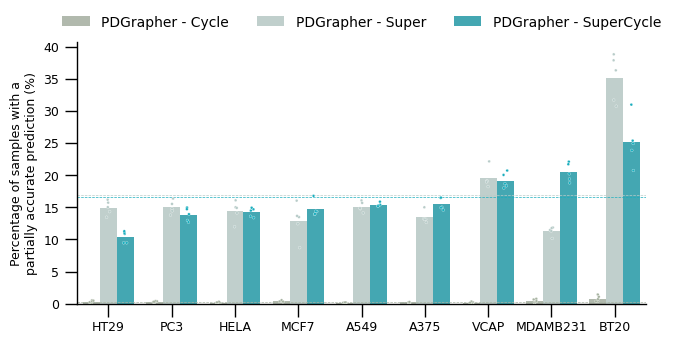

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Extract the data for 'rankings' into a DataFrame
metric = 'percentage of samples with partially accurate predictions'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()

# Order cell lines based on values for PDGrapher
pdgrapher_means = df_mean[df_mean['Method'] == 'PDGrapher - SuperCycle'].sort_values(by=metric)
ordered_cell_lines = pdgrapher_means['Cell Line']

# Reorder the DataFrame based on ordered cell lines
df['Cell Line'] = pd.Categorical(df['Cell Line'], categories=ordered_cell_lines, ordered=True)
df_mean['Cell Line'] = pd.Categorical(df_mean['Cell Line'], categories=ordered_cell_lines, ordered=True)

# Define a color palette that matches the existing figures
palette = {
    'PDGrapher - Super': '#B8CCC9',
    'PDGrapher - Cycle': '#A8B4A2',
    'PDGrapher - SuperCycle': '#1AAEBE',
}

# Define the order of methods
method_order = ['PDGrapher - Cycle', 'PDGrapher - Super', 'PDGrapher - SuperCycle']

with sns.plotting_context(plotting_context):
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(7.35, 3.4))

    # Create a bar plot for each method
    sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)

    # Overlay individual data points
    sns.stripplot(data=df, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=2, edgecolor="white", linewidth=0.2)





    # Add horizontal lines for the overall mean ranking for each method
    for method in method_order:
        overall_mean = df[df['Method'] == method][metric].mean()
        plt.axhline(y=overall_mean, linestyle='--', color=palette[method], linewidth=0.5)

    # Remove title
    plt.title('')
    plt.ylim

    # Remove X-axis label
    plt.xlabel('')
    sns.despine()

    # Adjust legend to only include the bars and place it at the top
    handles, labels = plt.gca().get_legend_handles_labels()
    bar_handles = handles[:len(method_order)]
    bar_labels = labels[:len(method_order)]
    plt.legend(bar_handles, bar_labels, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, frameon=False, title=None)

    plt.ylabel('Percentage of samples with a\npartially accurate prediction (%)')
    plt.savefig(osp.join(outdir, 'panel_partially_accurate_pred.pdf'))
    plt.show()




## Panel ranking

/tmp/ipykernel_3735631/172653242.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


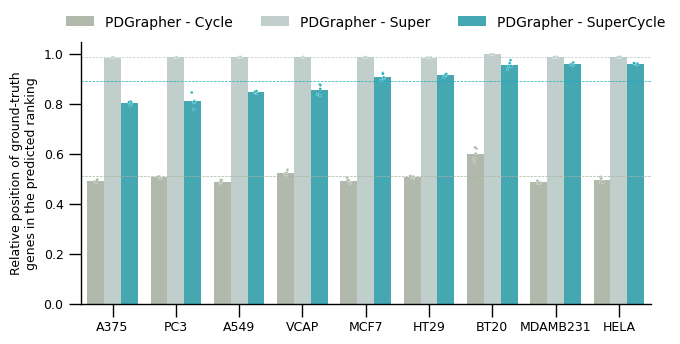

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Extract the data for 'rankings' into a DataFrame
metric = 'rankings'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()

# Order cell lines based on values for PDGrapher
pdgrapher_means = df_mean[df_mean['Method'] == 'PDGrapher - SuperCycle'].sort_values(by=metric)
ordered_cell_lines = pdgrapher_means['Cell Line']

# Reorder the DataFrame based on ordered cell lines
df['Cell Line'] = pd.Categorical(df['Cell Line'], categories=ordered_cell_lines, ordered=True)
df_mean['Cell Line'] = pd.Categorical(df_mean['Cell Line'], categories=ordered_cell_lines, ordered=True)

# Define a color palette that matches the existing figures
palette = {
    'PDGrapher - Super': '#B8CCC9',
    'PDGrapher - Cycle': '#A8B4A2',
    'PDGrapher - SuperCycle': '#1AAEBE',
}

# Define the order of methods
method_order = ['PDGrapher - Cycle', 'PDGrapher - Super', 'PDGrapher - SuperCycle']

with sns.plotting_context(plotting_context):
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(7.35, 3.4))

    # Create a bar plot for each method
    sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)

    # Overlay individual data points
    sns.stripplot(data=df, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=2, edgecolor="white", linewidth=0.2)





    # Add horizontal lines for the overall mean ranking for each method
    for method in method_order:
        overall_mean = df[df['Method'] == method][metric].mean()
        plt.axhline(y=overall_mean, linestyle='--', color=palette[method], linewidth=0.5)

    # Remove title
    plt.title('')
    plt.ylim

    # Remove X-axis label
    plt.xlabel('')
    sns.despine()

    # Adjust legend to only include the bars and place it at the top
    handles, labels = plt.gca().get_legend_handles_labels()
    bar_handles = handles[:len(method_order)]
    bar_labels = labels[:len(method_order)]
    plt.legend(bar_handles, bar_labels, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, frameon=False, title=None)

    plt.ylabel('Relative position of ground-truth\ngenes in the predicted ranking')
    plt.savefig(osp.join(outdir, 'panel_ranking.pdf'))
    plt.show()




## Panel recall@1

/tmp/ipykernel_3735631/1687818345.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


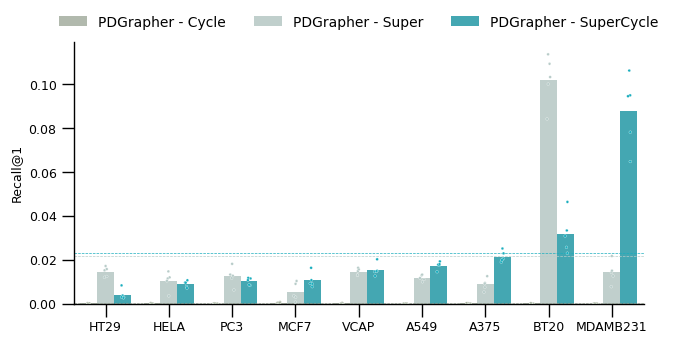

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Extract the data for 'rankings' into a DataFrame
metric = 'recall@1'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()

# Order cell lines based on values for PDGrapher
pdgrapher_means = df_mean[df_mean['Method'] == 'PDGrapher - SuperCycle'].sort_values(by=metric)
ordered_cell_lines = pdgrapher_means['Cell Line']

# Reorder the DataFrame based on ordered cell lines
df['Cell Line'] = pd.Categorical(df['Cell Line'], categories=ordered_cell_lines, ordered=True)
df_mean['Cell Line'] = pd.Categorical(df_mean['Cell Line'], categories=ordered_cell_lines, ordered=True)

# Define a color palette that matches the existing figures
palette = {
    'PDGrapher - Super': '#B8CCC9',
    'PDGrapher - Cycle': '#A8B4A2',
    'PDGrapher - SuperCycle': '#1AAEBE',
}

# Define the order of methods
method_order = ['PDGrapher - Cycle', 'PDGrapher - Super', 'PDGrapher - SuperCycle']

with sns.plotting_context(plotting_context):
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(7.35, 3.4))

    # Create a bar plot for each method
    sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)

    # Overlay individual data points
    sns.stripplot(data=df, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=2, edgecolor="white", linewidth=0.2)





    # Add horizontal lines for the overall mean ranking for each method
    for method in method_order:
        overall_mean = df[df['Method'] == method][metric].mean()
        plt.axhline(y=overall_mean, linestyle='--', color=palette[method], linewidth=0.5)

    # Remove title
    plt.title('')
    plt.ylim

    # Remove X-axis label
    plt.xlabel('')
    sns.despine()

    # Adjust legend to only include the bars and place it at the top
    handles, labels = plt.gca().get_legend_handles_labels()
    bar_handles = handles[:len(method_order)]
    bar_labels = labels[:len(method_order)]
    plt.legend(bar_handles, bar_labels, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, frameon=False, title=None)

    plt.ylabel('Recall@1')
    plt.savefig(osp.join(outdir, 'panel_recall@1.pdf'))
    plt.show()




## Panel recall@10

/tmp/ipykernel_3735631/3399697491.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


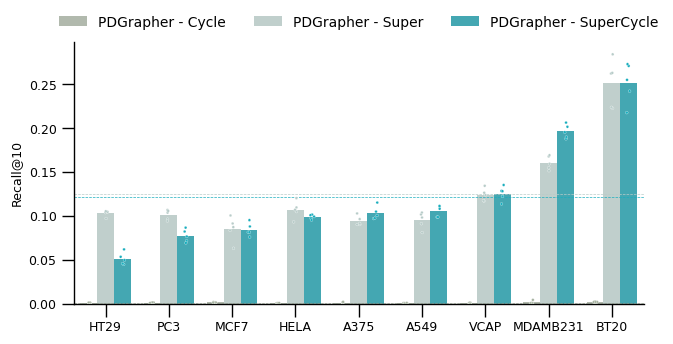

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Extract the data for 'rankings' into a DataFrame
metric = 'recall@10'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()

# Order cell lines based on values for PDGrapher
pdgrapher_means = df_mean[df_mean['Method'] == 'PDGrapher - SuperCycle'].sort_values(by=metric)
ordered_cell_lines = pdgrapher_means['Cell Line']

# Reorder the DataFrame based on ordered cell lines
df['Cell Line'] = pd.Categorical(df['Cell Line'], categories=ordered_cell_lines, ordered=True)
df_mean['Cell Line'] = pd.Categorical(df_mean['Cell Line'], categories=ordered_cell_lines, ordered=True)

# Define a color palette that matches the existing figures
palette = {
    'PDGrapher - Super': '#B8CCC9',
    'PDGrapher - Cycle': '#A8B4A2',
    'PDGrapher - SuperCycle': '#1AAEBE',
}

# Define the order of methods
method_order = ['PDGrapher - Cycle', 'PDGrapher - Super', 'PDGrapher - SuperCycle']

with sns.plotting_context(plotting_context):
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(7.35, 3.4))

    # Create a bar plot for each method
    sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)

    # Overlay individual data points
    sns.stripplot(data=df, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=2, edgecolor="white", linewidth=0.2)





    # Add horizontal lines for the overall mean ranking for each method
    for method in method_order:
        overall_mean = df[df['Method'] == method][metric].mean()
        plt.axhline(y=overall_mean, linestyle='--', color=palette[method], linewidth=0.5)

    # Remove title
    plt.title('')
    plt.ylim

    # Remove X-axis label
    plt.xlabel('')
    sns.despine()

    # Adjust legend to only include the bars and place it at the top
    handles, labels = plt.gca().get_legend_handles_labels()
    bar_handles = handles[:len(method_order)]
    bar_labels = labels[:len(method_order)]
    plt.legend(bar_handles, bar_labels, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, frameon=False, title=None)

    plt.ylabel('Recall@10')
    plt.savefig(osp.join(outdir, 'panel_recall@10.pdf'))
    plt.show()




## Recall@100

/tmp/ipykernel_3735631/63683113.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


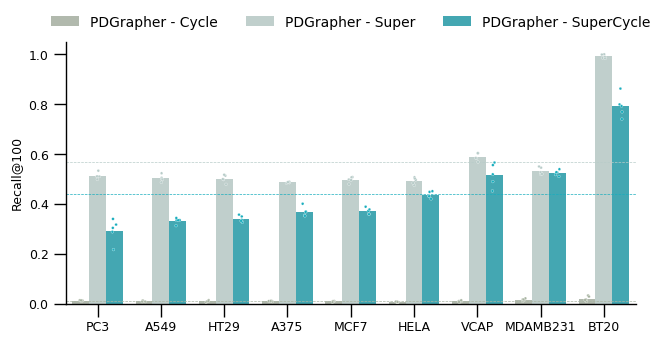

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Extract the data for 'rankings' into a DataFrame
metric = 'recall@100'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()

# Order cell lines based on values for PDGrapher
pdgrapher_means = df_mean[df_mean['Method'] == 'PDGrapher - SuperCycle'].sort_values(by=metric)
ordered_cell_lines = pdgrapher_means['Cell Line']

# Reorder the DataFrame based on ordered cell lines
df['Cell Line'] = pd.Categorical(df['Cell Line'], categories=ordered_cell_lines, ordered=True)
df_mean['Cell Line'] = pd.Categorical(df_mean['Cell Line'], categories=ordered_cell_lines, ordered=True)

# Define a color palette that matches the existing figures
palette = {
    'PDGrapher - Super': '#B8CCC9',
    'PDGrapher - Cycle': '#A8B4A2',
    'PDGrapher - SuperCycle': '#1AAEBE',
}

# Define the order of methods
method_order = ['PDGrapher - Cycle', 'PDGrapher - Super', 'PDGrapher - SuperCycle']

with sns.plotting_context(plotting_context):
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(7.35, 3.4))

    # Create a bar plot for each method
    sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)

    # Overlay individual data points
    sns.stripplot(data=df, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=2, edgecolor="white", linewidth=0.2)





    # Add horizontal lines for the overall mean ranking for each method
    for method in method_order:
        overall_mean = df[df['Method'] == method][metric].mean()
        plt.axhline(y=overall_mean, linestyle='--', color=palette[method], linewidth=0.5)

    # Remove title
    plt.title('')
    plt.ylim

    # Remove X-axis label
    plt.xlabel('')
    sns.despine()

    # Adjust legend to only include the bars and place it at the top
    handles, labels = plt.gca().get_legend_handles_labels()
    bar_handles = handles[:len(method_order)]
    bar_labels = labels[:len(method_order)]
    plt.legend(bar_handles, bar_labels, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, frameon=False, title=None)

    plt.ylabel('Recall@100')
    plt.savefig(osp.join(outdir, 'panel_recall@100.pdf'))
    plt.show()




## Panel recall@1000

/tmp/ipykernel_3735631/1385952125.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


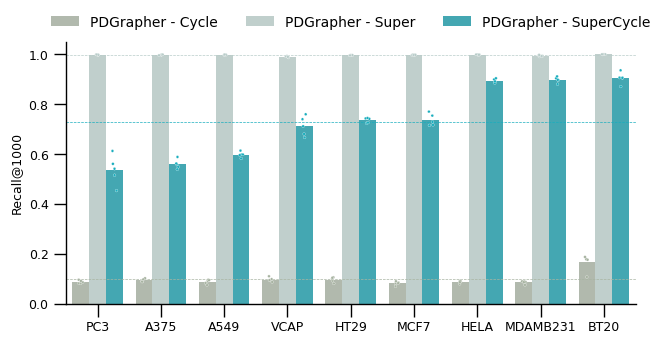

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Extract the data for 'rankings' into a DataFrame
metric = 'recall@1000'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()

# Order cell lines based on values for PDGrapher
pdgrapher_means = df_mean[df_mean['Method'] == 'PDGrapher - SuperCycle'].sort_values(by=metric)
ordered_cell_lines = pdgrapher_means['Cell Line']

# Reorder the DataFrame based on ordered cell lines
df['Cell Line'] = pd.Categorical(df['Cell Line'], categories=ordered_cell_lines, ordered=True)
df_mean['Cell Line'] = pd.Categorical(df_mean['Cell Line'], categories=ordered_cell_lines, ordered=True)

# Define a color palette that matches the existing figures
palette = {
    'PDGrapher - Super': '#B8CCC9',
    'PDGrapher - Cycle': '#A8B4A2',
    'PDGrapher - SuperCycle': '#1AAEBE',
}

# Define the order of methods
method_order = ['PDGrapher - Cycle', 'PDGrapher - Super', 'PDGrapher - SuperCycle']

with sns.plotting_context(plotting_context):
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(7.35, 3.4))

    # Create a bar plot for each method
    sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)

    # Overlay individual data points
    sns.stripplot(data=df, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=2, edgecolor="white", linewidth=0.2)





    # Add horizontal lines for the overall mean ranking for each method
    for method in method_order:
        overall_mean = df[df['Method'] == method][metric].mean()
        plt.axhline(y=overall_mean, linestyle='--', color=palette[method], linewidth=0.5)

    # Remove title
    plt.title('')
    plt.ylim

    # Remove X-axis label
    plt.xlabel('')
    sns.despine()

    # Adjust legend to only include the bars and place it at the top
    handles, labels = plt.gca().get_legend_handles_labels()
    bar_handles = handles[:len(method_order)]
    bar_labels = labels[:len(method_order)]
    plt.legend(bar_handles, bar_labels, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, frameon=False, title=None)

    plt.ylabel('Recall@1000')
    plt.savefig(osp.join(outdir, 'panel_recall@1000.pdf'))
    plt.show()


